In [ ]:
#Link of the original website: https://medium.com/@orenji.eirl/vanilla-risk-parity-with-python-and-riskfolio-lib-3dfbfb752067

In [15]:
import numpy as np
import pandas as pd
import yfinance as yf
import warnings


warnings.filterwarnings("ignore")
yf.pdr_override()
pd.options.display.float_format = '{:.4%}'.format

# Date range
start = '2021-11-01'
end = '2022-05-22'

# Tickers of assets
assets = ["SSO", "UBT", "UST", "UPW", "UGL"]
assets.sort()

# Downloading data
data = yf.download(assets, start = start, end = end)
data = data.loc[:,('Adj Close', slice(None))]
data.columns = assets
# Calculating returns
Y = data[assets].pct_change().dropna()

display(Y.head())

[*********************100%***********************]  5 of 5 completed


,SSO,UBT,UGL,UPW,UST
Date,,,,,
2021-11-02,0.7932%,0.6897%,-0.5009%,0.0306%,0.5048%
2021-11-03,1.2490%,-1.9993%,-1.7879%,-0.6419%,-0.5023%
2021-11-04,0.8842%,2.0212%,2.3330%,-1.0152%,0.9800%
2021-11-05,0.6997%,3.1105%,2.6770%,1.7094%,1.1910%
2021-11-08,0.1895%,-0.5387%,0.7569%,-2.7349%,-0.8573%


In [16]:
import riskfolio as rp

# Building the portfolio object
port = rp.Portfolio(returns=Y)

# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

# Estimate optimal portfolio:

model='Classic' # Could be Classic (historical) or FM (Factor Model)
rm = 'MV' # Risk measure used, this time will be variance
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
b = None # Risk contribution constraints vector
w_rp = port.rp_optimization(model=model, rm=rm, rf=rf, b=b, hist=hist)

display(w_rp.T)

,SSO,UBT,UGL,UPW,UST
weights,16.8004%,14.2771%,21.2345%,16.5763%,31.1118%


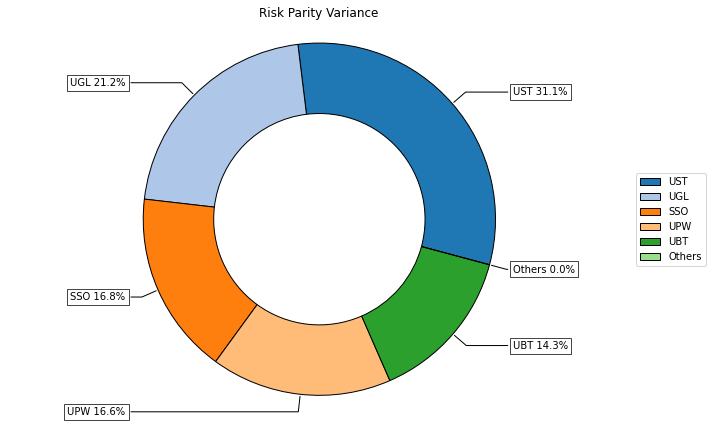

In [23]:
# Plotting the composition of the portfolio

ax = rp.plot_pie(w=w_rp,
                 title='Risk Parity Variance',
                 others=0.05,
                 nrow=25,
                 cmap = "tab20",
                 height=6,
                 width=10,
                 ax=None)

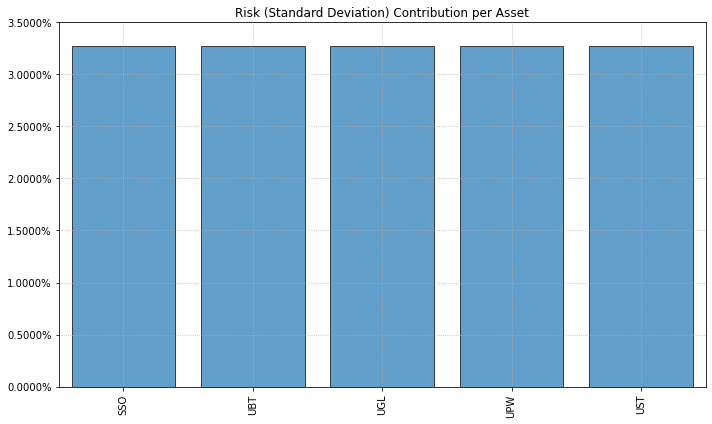

In [20]:
# Plotting the risk contribution per asset

mu = Y.mean()
cov = Y.cov() # Covariance matrix
returns = Y # Returns of the assets

ax = rp.plot_risk_con(w=w_rp,
                      cov=cov,
                      returns=returns,
                      rm=rm,
                      rf=0,
                      alpha=0.05,
                      color="tab:blue",
                      height=6,
                      width=10,
                      t_factor=252,
                      ax=None)

In [21]:
# Risk Measures available:
#
# 'MV': Standard Deviation.
# 'MAD': Mean Absolute Deviation.
# 'MSV': Semi Standard Deviation.
# 'FLPM': First Lower Partial Moment (Omega Ratio).
# 'SLPM': Second Lower Partial Moment (Sortino Ratio).
# 'CVaR': Conditional Value at Risk.
# 'EVaR': Entropic Value at Risk.
# 'CDaR': Conditional Drawdown at Risk of uncompounded cumulative returns.
# 'EDaR': Entropic Drawdown at Risk of uncompounded cumulative returns.
# 'UCI': Ulcer Index of uncompounded cumulative returns.

rms = ['MV', 'MAD', 'MSV', 'FLPM', 'SLPM', 'CVaR',
       'EVaR', 'CDaR', 'UCI', 'EDaR']

w_s = pd.DataFrame([])

for i in rms:
    w = port.rp_optimization(model=model, rm=i, rf=rf, b=b, hist=hist)
    w_s = pd.concat([w_s, w], axis=1)
    
w_s.columns = rms
w_s.style.format("{:.2%}").background_gradient(cmap='YlGn')

,MV,MAD,MSV,FLPM,SLPM,CVaR,EVaR,CDaR,UCI,EDaR
SSO,16.80%,2.39%,15.93%,11.97%,12.94%,13.29%,11.33%,10.77%,13.24%,11.04%
UBT,14.28%,0.00%,13.85%,0.00%,0.00%,13.18%,12.02%,9.02%,9.93%,9.12%
UGL,21.23%,61.03%,21.83%,0.00%,0.00%,28.16%,31.13%,24.29%,27.25%,24.65%
UPW,16.58%,10.77%,16.63%,20.45%,15.21%,15.33%,16.72%,31.79%,28.61%,31.41%
UST,31.11%,25.80%,31.77%,67.58%,71.85%,30.04%,28.81%,24.13%,20.97%,23.78%


<AxesSubplot:>

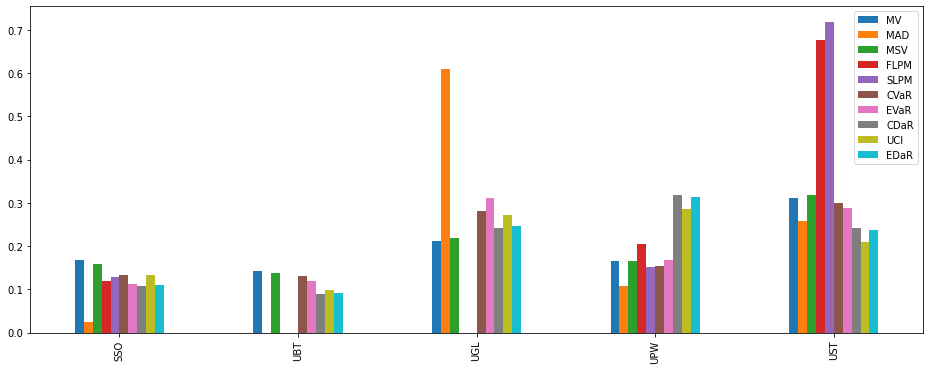

In [22]:
import matplotlib.pyplot as plt

# Plotting a comparison of assets weights for each portfolio

fig = plt.gcf()
fig.set_figwidth(16)
fig.set_figheight(6)
ax = fig.subplots(nrows=1, ncols=1)

w_s.plot.bar(ax=ax)